## [2주차] 기본과제 - 주어진 문장에서 나올 다음 단어를 예측하는 모델 구현

이번 과제에서는 Transformer를 last word prediction이라는 task에 적용합니다.
Last word prediction은 Token list가 주어졌을 때, 다음으로 오는 token을 예측하는 task로, 추후 등장할 LLM의 핵심입니다.

In [1]:
!pip install datasets sacremoses

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### 1. Last word prediction dataset 준비
* collate_fn 함수 정의

In [2]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from torch.nn.utils.rnn import pad_sequence

# 데이터셋 로드하기
train_ds = load_dataset("imdb", split="train[:5%]")
test_ds = load_dataset("imdb", split="test[:5%]")

# 권장 방식으로 토크나이저 로드하기
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


def collate_fn(batch):
    max_len = 400
    texts, labels = [], []
    for row in batch:
        # 문장을 토큰화하고, 마지막 세 번째 단어를 라벨로 설정
        tokenized = tokenizer(row['text'], truncation=True, max_length=max_len).input_ids

        if len(tokenized) < 3:  # 너무 짧은 문장은 건너뛰기
            continue

        labels.append(tokenized[-3])  # 마지막 세 번째 단어를 라벨로 사용
        texts.append(torch.LongTensor(
            tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[:-3]))  # 마지막 세 단어를 제외한 입력 문장

    # 입력 문장을 패딩 처리하여 동일한 길이로 맞춤
    texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
    labels = torch.LongTensor(labels)

    return texts, labels


train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)

C:\Users\rlgus\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. SelfAttention 구현

In [3]:
from torch import nn
from math import sqrt


class SelfAttention(nn.Module):
    def __init__(self, input_dim, d_model):
        super().__init__()

        self.input_dim = input_dim
        self.d_model = d_model

        self.wq = nn.Linear(input_dim, d_model)
        self.wk = nn.Linear(input_dim, d_model)
        self.wv = nn.Linear(input_dim, d_model)
        self.dense = nn.Linear(d_model, d_model)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask):
        q, k, v = self.wq(x), self.wk(x), self.wv(x)
        score = torch.matmul(q, k.transpose(-1, -2))  # (B, S, D) * (B, D, S) = (B, S, S)
        score = score / sqrt(self.d_model)

        if mask is not None:
            score = score + (mask * -1e9)

        score = self.softmax(score)
        result = torch.matmul(score, v)
        result = self.dense(result)

        return result

### 3. TransformerLayer 구현

In [4]:
class TransformerLayer(nn.Module):
    def __init__(self, input_dim, d_model, dff):
        super().__init__()

        self.input_dim = input_dim
        self.d_model = d_model
        self.dff = dff

        self.sa = SelfAttention(input_dim, d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Linear(dff, d_model)
        )

    def forward(self, x, mask):
        x = self.sa(x, mask)
        x = self.ffn(x)

        return x

### 4. positional_encoding 구현

In [5]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


### 5. TextClassifier 구현
* self.classification을 Binary Classification에서 General Classification으로 변경 (1 -> vocab_size)
* forward 함수에서 classification 하기전 x 값을 마지막 토큰의 출력만 사용하므로 (0 -> -1)로 변경

In [6]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, dff):
        super().__init__()

        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.dff = dff

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
        self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])
        # 모델이 각 단어의 확률을 계산
        self.classification = nn.Linear(d_model, vocab_size)  # 이진분류에서 General Classification으로 변경

    def forward(self, x):
        mask = (x == tokenizer.pad_token_id)
        mask = mask[:, None, :]
        seq_len = x.shape[1]

        x = self.embedding(x)
        x = x * sqrt(self.d_model)
        x = x + self.pos_encoding[:, :seq_len]

        for layer in self.layers:
            x = layer(x, mask)

        x = x[:, -1]  # 마지막 토큰의 출력만 사용하므로 -1로 변경
        x = self.classification(x)

        return x


model = TextClassifier(len(tokenizer), 32, 2, 32)

## 6. 손실함수 및 정확도(accuracy) 함수 정의
* 손실함수를 (`nn.BCEWithLogitsLoss` -> `nn.CrossEntropyLoss`)로 변경.
* 모델의 출력(`preds`)를 `torch.argmax()`를 사용하여 예측 값을 얻도록 변경.

이유?
1. 다중 클래스 분류 문제이기 때문
    * 가장 확률이 높은 단어의 인덱스를 예측 값으로 선택함.
2. 모델의 출력은 logit이기 때문
    * `preds`는 `Linear Layer`를 통과한 후, 아직 Softmax 함수를 적용하지 않은 상태임.
    * 따라서, 출력 값은 확률 값이 아니고, 단순한 logit 임.
    * **값이 클수록 해당 클래스(단어)의 확률이 더 높다고 판단함.**
3. `nn.CrossEntropyLoss()`와 연동하기 위해
    * 현재 사용하는 손실함수는 `nn.CrossEntropyLoss()` 임
    * 내부적으로 softmax 연산을 포함함.
    * 따라서 `preds`는 `torch.argmax()`를 사용해 예측 값을 얻어야 함.

In [7]:
from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
# loss_fn = nn.BCEWithLogitsLoss()
loss_fn = nn.CrossEntropyLoss()  # General Classification (단어 예측)

optimizer = Adam(model.parameters(), lr=lr)

In [8]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)
        preds = torch.argmax(preds, dim=-1)  # 가장 높은 확률의 단어를 예측 값으로 사용

        cnt += labels.shape[0]
        acc += (labels == preds).sum().item()

    return acc / cnt

### 7. 학습

**평균 손실 계산 추가**
1. 데이터 Batch 처리 때문
    * 딥러닝은 전체 데이터셋을 한 번에 처리하지 않고, 여러 개의 작은 배치로 나누어 학습함.
    * 배치 마다 손실 값이 계산되는데, 단순히 더하는 것은 의미가 없음.
        * 배치마다 데이터의 개수가 같지 않을 수도 있기 때문임.
2. 손실 값의 크기 비교를 하기 위해서
    * 배치 크기와 관계없이 일정하게 비교할 수 있도록 손실 값을 평균으로 계산하는 것이 좋음.
3. 학습률 설정의 편의성
    * 손실 값이 너무 커지면 학습률이 너무 작아져서 학습이 느려지는 현상이 발생할 수 있기 때문에 평균 손실을 사용하면 학습률 설정이 쉬워짐.


**epoch 수 (5 -> 10)으로 변경**
* Train Loss는 줄어들고 있지만, 정확도는 거의 증가하지 않고 있음.
* epoch을 늘린다고 해서 개선될 여지는 없어보이지만, Epoch 수를 변경해보았음.


In [10]:
n_epochs = 10
train_losses = []
train_accs = []
test_accs = []

for epoch in range(n_epochs):
    total_loss = 0.
    model.train()  # 모델을 훈련 모드로 설정
    for data in train_loader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # 평균 손실 계산
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch:3d} | Train Loss: {avg_loss:.4f}")

    with torch.no_grad():
        model.eval()  # 모델을 평가모드로 설정

        # Train Accuracy 계산
        train_acc = accuracy(model, train_loader)
        train_accs.append(train_acc)

        # Test Accuracy 계산
        test_acc = accuracy(model, test_loader)
        test_accs.append(test_acc)

        print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Epoch   0 | Train Loss: 5.9433
=========> Train acc: 0.040 | Test acc: 0.049
Epoch   1 | Train Loss: 5.8968
=========> Train acc: 0.041 | Test acc: 0.024
Epoch   2 | Train Loss: 5.8525
=========> Train acc: 0.040 | Test acc: 0.049
Epoch   3 | Train Loss: 5.8406
=========> Train acc: 0.041 | Test acc: 0.024
Epoch   4 | Train Loss: 5.8237
=========> Train acc: 0.040 | Test acc: 0.049
Epoch   5 | Train Loss: 5.8030
=========> Train acc: 0.040 | Test acc: 0.049
Epoch   6 | Train Loss: 5.8042
=========> Train acc: 0.041 | Test acc: 0.024
Epoch   7 | Train Loss: 5.8044
=========> Train acc: 0.040 | Test acc: 0.049
Epoch   8 | Train Loss: 5.7920
=========> Train acc: 0.041 | Test acc: 0.024
Epoch   9 | Train Loss: 5.7844
=========> Train acc: 0.042 | Test acc: 0.024


### 8. 학습 결과 시각화

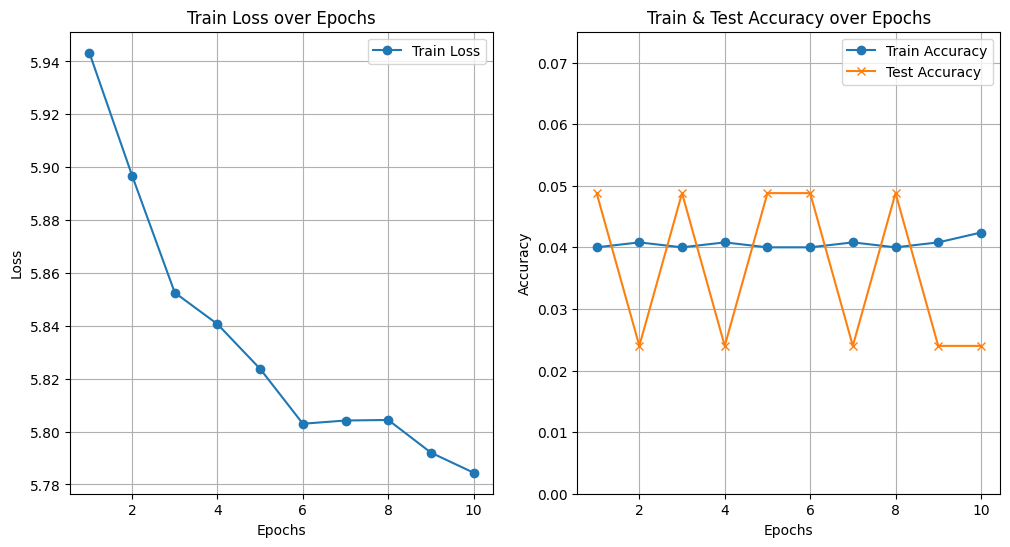

In [42]:
# 학습 결과 시각화
epochs = range(1, n_epochs + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# 첫 번째 그래프: Train Loss
ax1.plot(epochs, train_losses, label='Train Loss', marker='o')
ax1.set_title('Train Loss over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')
ax1.grid(True)

# 두 번째 그래프: Train & Test Accuracy
ax2.plot(epochs, train_accs, label='Train Accuracy', marker='o')
ax2.plot(epochs, test_accs, label='Test Accuracy', marker='x')
ax2.set_title('Train & Test Accuracy over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

ax2.set_ylim(0.0, 0.075)
ax2.legend(loc='upper right')
ax2.grid(True)

plt.show()

### 9. 그래프 결과 분석
1. Train Loss 그래프
    * Train Loss가 꾸준히 감소하는 모습
    * 학습이 진행되면서 손실 값이 점점 줄어드는 건 모델이 학습을 잘하고 있음을 의미
    * 하지만 **감소 속도가 빠르지 않기 때문에 학습이 느리게 진행되고 있을 가능성**이 있음
2. Train & Test Accuracy 그래프
    * Train Accuracy는 **0.04 (4%) 정도에서 조금씩 증가하고 있음**.
    * Test Accuracy는 **위아래로 많이 변동되고 있음**.
        * 특히, 정확도가 0.05 (5%) 에서 0.02 (2%) 정도로 크게 떨어지기도 함.
        * 학습이 잘 되지 않거나, 모델이 Overfitting 또는 Underfitting 되고 있을 가능성이 있음.


### 문제 분석
1. **Train Loss는 감소하고 있지만, 정확도는 증가하지 않음.**
    * 학습 데이터의 overfitting 가능성.
    * 모델이 학습 데이터의 패턴을 제대로 잡지 못하고 있을 수 있음.
2. **Test Accuracy의 변동이 매우 큼**
    * 데이터셋이 너무 작거나, 모델이 데이터의 패턴을 제대로 학습하지 못함.
    * 학습률이 너무 크거나 작을 때 발생할 수 있음.


### 개선 방안
💡학습률을 절반으로 조정하여 (lr = 0.0005)로 다시 학습해보기<br/>
💡Transformer Layer 수 (`n_layers`)를 늘리거나, `d_model` 크기를 키워보기<br/>
`model = TextClassifier(vocab_size=len(tokenizer), d_model=64, n_layers=4, dff=128)`<br/>
💡IMDB 데이터셋을 늘려보기 (현재 5% -> 10%, 20%, 50%)<br/>
💡MNIST 심화학습에 사용해본 Dropout Layer를 추가하여 Overfitting 방지 해보기<br/>

